In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from pvlib.solarposition import get_solarposition
from sklearn.linear_model import LinearRegression
from dask.distributed import Client
from dask import delayed
import traceback

In [2]:
data = pd.read_csv("/Users/dgagne/data/cabauw_derived_data.csv", index_col="Time", parse_dates=["Time"])

In [4]:
c_lat = 51.971
c_lon = 4.927
sol_pos_data = get_solarposition(data.index, c_lat, c_lon, method="nrel_numba")

In [20]:
np.count_nonzero(data["obukhov length_surface_m"] == 0)

104

0.1902802857815812

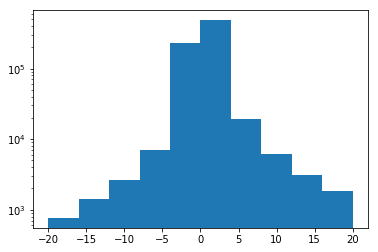

In [19]:
zol = (10 / data.loc[data["obukhov length_surface_m"] != 0, "obukhov length_surface_m"])
plt.hist(zol[np.abs(zol) < 20])
plt.gca().set_yscale("log")
np.count_nonzero((zol < -2) | (zol > 1)) / zol.shape[0]

In [5]:
data["zenith"] = sol_pos_data["zenith"]
data["azimuth"] = sol_pos_data["azimuth"]

In [3]:
data.columns

Index(['temperature_10 m_K', 'pressure_2 m_hPa',
       'potential temperature_10 m_K', 'mixing ratio_10 m_g kg-1',
       'virtual potential temperature_10 m_K', 'air density_10 m_kg m-3',
       'wind speed_10 m_m s-1', 'wind direction_10 m_m s-1',
       'u wind_10 m_m s-1', 'v wind_10 m_m s-1', 'mixing ratio_2 m_g kg-1',
       'temperature_0 m_K', 'potential temperature_0 m_K',
       'virtual potential temperature_0 m_K', 'friction velocity_surface_K',
       'temperature scale_surface_K', 'moisture scale_surface_g kg-1',
       'bulk richardson_surface_', 'obukhov length_surface_m'],
      dtype='object')

In [3]:
data["friction velocity_surface_K"].min()

0.0

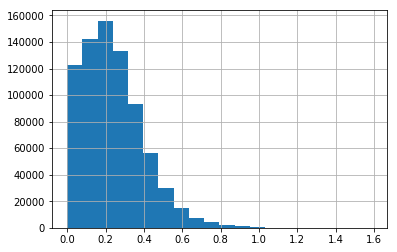

In [9]:
data["friction velocity_surface_K"].hist(bins=20)

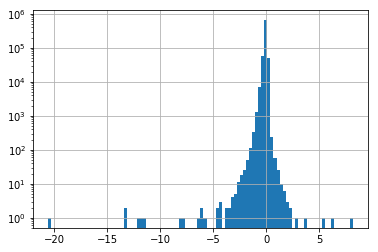

In [6]:
data["temperature scale_surface_K"].hist(bins=100)
plt.gca().set_yscale("log")

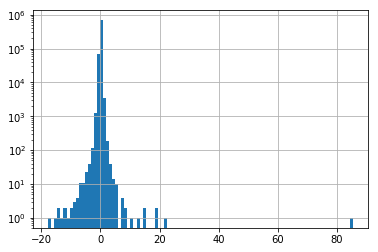

In [10]:
data["moisture scale_surface_g kg-1"].hist(bins=100)
plt.gca().set_yscale("log")

In [11]:
for col in data.columns:
    print(col.split("_"))

['temperature', '10 m', 'K']
['pressure', '2 m', 'hPa']
['potential temperature', '10 m', 'K']
['mixing ratio', '10 m', 'g kg-1']
['virtual potential temperature', '10 m', 'K']
['air density', '10 m', 'kg m-3']
['wind speed', '10 m', 'm s-1']
['wind direction', '10 m', 'm s-1']
['u wind', '10 m', 'm s-1']
['v wind', '10 m', 'm s-1']
['mixing ratio', '2 m', 'g kg-1']
['temperature', '0 m', 'K']
['potential temperature', '0 m', 'K']
['virtual potential temperature', '0 m', 'K']
['friction velocity', 'surface', 'K']
['temperature scale', 'surface', 'K']
['moisture scale', 'surface', 'g kg-1']
['bulk richardson', 'surface', '']
['obukhov length', 'surface', 'm']


In [6]:
train_data = data.loc[data.index < "2011-01-01"]
test_data = data.loc[data.index >= "2011-01-01"]

In [7]:
client = Client()

In [8]:
client

Client Scheduler: tcp://127.0.0.1:51627 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 8 Memory: 17.18 GB


In [9]:
remote_train = client.scatter(train_data)
remote_test = client.scatter(test_data)

TypeError: 'Future' object is not subscriptable

In [10]:
input_columns = ['virtual potential temperature_10 m_K', "pressure_2 m_hPa", "mixing ratio_10 m_g kg-1",
                 'wind speed_10 m_m s-1', 'u wind_10 m_m s-1', 'v wind_10 m_m s-1', 'mixing ratio_2 m_g kg-1',
                'virtual potential temperature_0 m_K', 'bulk richardson_surface_', "zenith", "azimuth"]
output_columns = ['friction velocity_surface_K','temperature scale_surface_K', 'moisture scale_surface_g kg-1',]

In [46]:
@delayed
def rmse(preds, obs):
    return np.sqrt(np.mean((preds - obs) ** 2))

@delayed
def train_rf(num_trees, train_data, input_columns, output_column):
    rf = RandomForestRegressor(n_estimators=num_trees, n_jobs=1)
    rf.fit(train_data[input_columns], train_data[[output_column]])
    return rf

@delayed
def test_rf(rf, test_data, input_columns):
    return rf.predict(test_data[input_columns])

In [37]:
num_trees = [20, 25, 30, 35]
res = []
for nt in num_trees:
    res.append(client.submit(train_rf, nt, remote_train, remote_test, input_columns, output_columns[1]))

In [39]:
del res[:]

In [47]:
num_trees = [20, 25, 30, 35]
res = []
for nt in num_trees:
    rf = train_rf(nt, train_data, input_columns, output_columns[1])
    rf_preds = test_rf(rf, test_data, input_columns)
    res.append(rmse(rf_preds, test_data[output_columns[1]]))
delayed(np.mean)(res).compute()

0.09569392736989675

In [48]:
res

[Delayed('rmse-df77d84e-9ce8-455f-b4b7-af76604a0a66'),
 Delayed('rmse-d0ff684a-57b2-4a08-937d-eccf61815ba7'),
 Delayed('rmse-f050fece-56f5-43f0-a1d4-cad3e1692344'),
 Delayed('rmse-201f75c2-e671-480c-9ca8-10d59f402081')]

In [29]:
print(traceback.extract_tb(res[1].traceback())[1])

<FrameSummary file /Users/dgagne/miniconda3/envs/deep/lib/python3.6/site-packages/pandas/core/generic.py, line 4376 in __getattr__>


In [7]:
train_data.columns

Index(['temperature_10 m_K', 'pressure_2 m_hPa',
       'potential temperature_10 m_K', 'mixing ratio_10 m_g kg-1',
       'virtual potential temperature_10 m_K', 'air density_10 m_kg m-3',
       'wind speed_10 m_m s-1', 'wind direction_10 m_m s-1',
       'u wind_10 m_m s-1', 'v wind_10 m_m s-1', 'mixing ratio_2 m_g kg-1',
       'temperature_0 m_K', 'potential temperature_0 m_K',
       'virtual potential temperature_0 m_K', 'friction velocity_surface_K',
       'temperature scale_surface_K', 'moisture scale_surface_g kg-1',
       'bulk richardson_surface_', 'obukhov length_surface_m'],
      dtype='object')

In [7]:
rf_models = []
day_time = train_data["zenith"] < 90
for o, output_column in enumerate(output_columns):
    rf_models.append(RandomForestRegressor(n_estimators=50, verbose=2, n_jobs=4, criterion="mse"))
    rf_models[-1].fit(train_data.loc[day_time, input_columns], train_data.loc[day_time, output_column])

building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   19.6s


building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:   28.1s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   20.7s


building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:   29.8s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   21.6s


building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:   30.8s finished


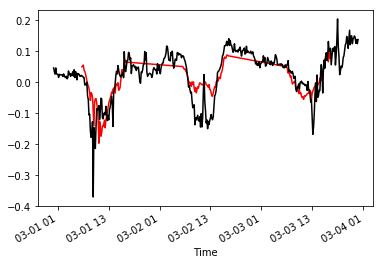

In [27]:
rf_preds.loc["2014-03-01":"2014-03-03","temperature scale_surface_K"].plot(color="red")
test_data.loc["2014-03-01":"2014-03-03", "temperature scale_surface_K"].plot(color="k")

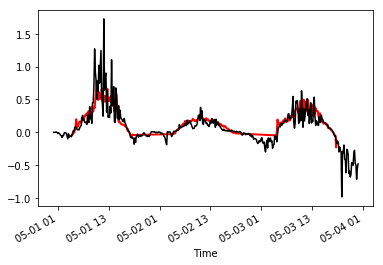

In [47]:
rf_preds.loc["2014-05-01":"2014-05-03","moisture scale_surface_g kg-1"].plot(color="red", lw=2)
test_data.loc["2014-05-01":"2014-05-03", "moisture scale_surface_g kg-1"].plot(color="k")

In [8]:
test_day_time = test_data["zenith"] < 90
rf_preds = pd.DataFrame(index=test_data.index[test_day_time], columns=output_columns, dtype=float)
for o, output_column in enumerate(output_columns):
    rf_preds[output_column] = rf_models[o].predict(test_data.loc[test_day_time, input_columns])

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    1.0s finished
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    1.1s finished


/Users/dgagne/miniconda3/envs/deep/lib/python3.6/site-packages/matplotlib/colors.py:1031: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


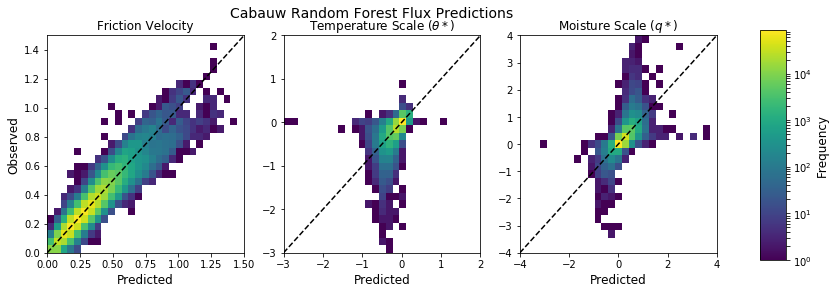

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
cax = fig.add_axes([0.95,0.1, 0.03, 0.8])
bins = [np.linspace(0, 1.5, 30),
        np.linspace(-3, 2, 30),
        np.linspace(-4, 4, 30)]
titles = ["Friction Velocity", "Temperature Scale ($\\theta *$)", "Moisture Scale ($q*$)"]
for a, ax in enumerate(axes):
    h_obj = ax.hist2d(rf_preds[output_columns[a]], test_data.loc[test_day_time, output_columns[a]], cmin=1, bins=bins[a], norm=LogNorm())
    ax.plot(bins[a], bins[a],'k--')
    ax.set_title(titles[a])
    if a == 0:
        ax.set_ylabel("Observed", fontsize=12)
    ax.set_xlabel("Predicted", fontsize=12)
cbar = plt.colorbar(h_obj[-1], cax=cax)
cbar.set_label(label="Frequency", fontsize=12)
fig.suptitle("Cabauw Random Forest Flux Predictions", fontsize=14)
plt.savefig("cabauw_rf_flux_hist.png", dpi=200, bbox_inches="tight")

/Users/dgagne/miniconda3/envs/deep/lib/python3.6/site-packages/matplotlib/colors.py:1031: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


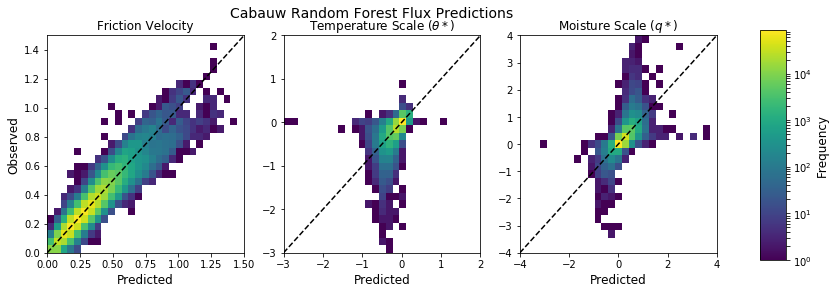

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
cax = fig.add_axes([0.95,0.1, 0.03, 0.8])
bins = [np.linspace(0, 1.5, 30),
        np.linspace(-3, 2, 30),
        np.linspace(-4, 4, 30)]
titles = ["Friction Velocity", "Temperature Scale ($\\theta *$)", "Moisture Scale ($q*$)"]
for a, ax in enumerate(axes):
    h_obj = ax.hist2d(rf_preds[output_columns[a]], test_data.loc[test_day_time, output_columns[a]], cmin=1, bins=bins[a], norm=LogNorm())
    ax.plot(bins[a], bins[a],'k--')
    ax.set_title(titles[a])
    if a == 0:
        ax.set_ylabel("Observed", fontsize=12)
    ax.set_xlabel("Predicted", fontsize=12)
cbar = plt.colorbar(h_obj[-1], cax=cax)
cbar.set_label(label="Frequency", fontsize=12)
fig.suptitle("Cabauw Random Forest Flux Predictions", fontsize=14)
plt.savefig("cabauw_rf_flux_hist.png", dpi=200, bbox_inches="tight")

In [49]:
ranked_imp = np.argsort(rf_models[2].feature_importances_)[::-1]
for i, col in enumerate(np.array(input_columns)[ranked_imp]):
    print(col, rf_models[2].feature_importances_[ranked_imp[i]] * 100)

zenith 34.89212825086117
bulk richardson_surface_ 15.288413266077711
wind speed_10 m_m s-1 14.51088646373816
azimuth 6.7685945374067105
pressure_2 m_hPa 6.012966101535653
v wind_10 m_m s-1 5.456875431318797
virtual potential temperature_10 m_K 3.9433506347558245
virtual potential temperature_0 m_K 3.686037373273371
mixing ratio_10 m_g kg-1 3.6683342315705025
u wind_10 m_m s-1 3.4917485612209287
mixing ratio_2 m_g kg-1 2.2806651482411704


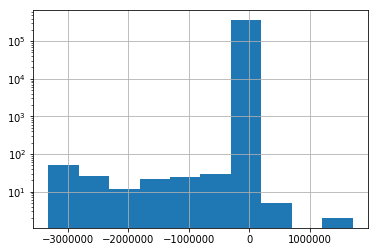

In [52]:
test_data["bulk richardson_surface_"].hist()
plt.gca().set_yscale("log")

(-20, 20)

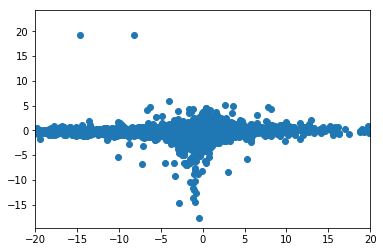

In [61]:
plt.scatter(train_data["bulk richardson_surface_"], train_data[output_columns[2]])
plt.xlim(-20, 20)

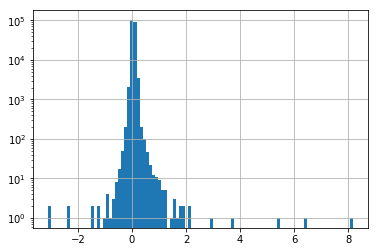

In [29]:
train_data.loc[train_data["zenith"] > 90, "temperature scale_surface_K"].hist(bins=100)
plt.gca().set_yscale("log")

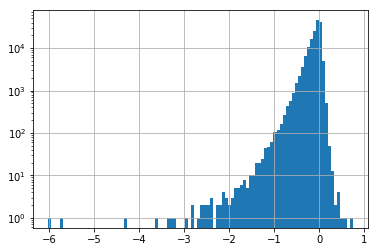

In [30]:
train_data.loc[train_data["zenith"] < 80, "temperature scale_surface_K"].hist(bins=100)
plt.gca().set_yscale("log")

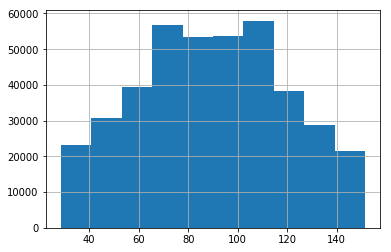

In [22]:
train_data["zenith"].hist()

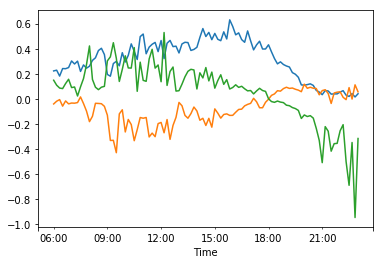

In [12]:
train_data.loc["2005-05-10 06:00":"2005-05-10 23:00","friction velocity_surface_K"].plot()
train_data.loc["2005-05-10 06:00":"2005-05-10 23:00","temperature scale_surface_K"].plot()
train_data.loc["2005-05-10 06:00":"2005-05-10 23:00","moisture scale_surface_g kg-1"].plot()

In [56]:
np.corrcoef(train_data[["friction velocity_surface_K", 
                        "temperature scale_surface_K", 
                        "moisture scale_surface_g kg-1"]].values.T)

array([[ 1.        , -0.08067959,  0.24429597],
       [-0.08067959,  1.        , -0.5797052 ],
       [ 0.24429597, -0.5797052 ,  1.        ]])

In [70]:
train_data["time"] = train_data.index.time

/Users/dgagne/miniconda3/envs/deep/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


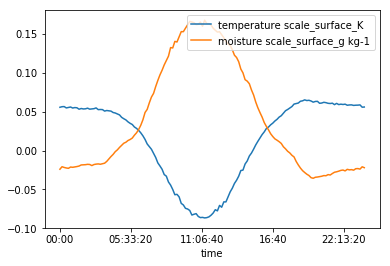

In [77]:
train_data.groupby("time")[["temperature scale_surface_K","moisture scale_surface_g kg-1"]].median().plot()

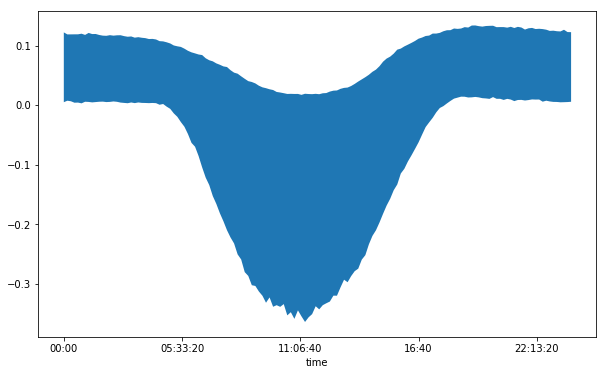

In [88]:
#train_data.groupby("time")[["temperature scale_surface_K","moisture scale_surface_g kg-1"]].median().plot()
fig, ax = plt.subplots(figsize=(10, 6))
p90 = train_data.groupby("time")[["temperature scale_surface_K","moisture scale_surface_g kg-1"]].quantile(0.9)
p10 = train_data.groupby("time")[["temperature scale_surface_K","moisture scale_surface_g kg-1"]].quantile(0.1)
ax.fill_between(p90.index, p90["temperature scale_surface_K"], p10["temperature scale_surface_K"])

In [ ]:
train_data

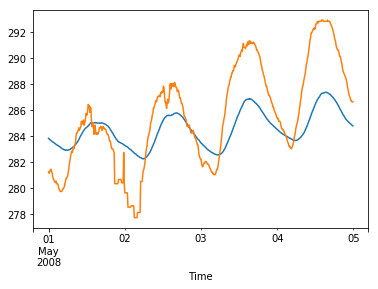

In [43]:
train_data.loc["2008-05-01":"2008-05-04","temperature_0 m_K"].plot()
train_data.loc["2008-05-01":"2008-05-04","temperature_10 m_K"].plot()


In [42]:
train_data.columns

Index(['temperature_10 m_K', 'pressure_2 m_hPa',
       'potential temperature_10 m_K', 'mixing ratio_10 m_g kg-1',
       'virtual potential temperature_10 m_K', 'air density_10 m_kg m-3',
       'wind speed_10 m_m s-1', 'wind direction_10 m_m s-1',
       'u wind_10 m_m s-1', 'v wind_10 m_m s-1', 'mixing ratio_2 m_g kg-1',
       'temperature_0 m_K', 'potential temperature_0 m_K',
       'virtual potential temperature_0 m_K', 'friction velocity_surface_K',
       'temperature scale_surface_K', 'moisture scale_surface_g kg-1',
       'bulk richardson_surface_', 'obukhov length_surface_m', 'zenith',
       'azimuth'],
      dtype='object')

In [52]:
lm = LinearRegression()
lm.fit(train_data[["zenith"]], train_data["temperature scale_surface_K"])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [54]:
l_preds = lm.predict(test_data[["zenith"]])

(-4, 1)

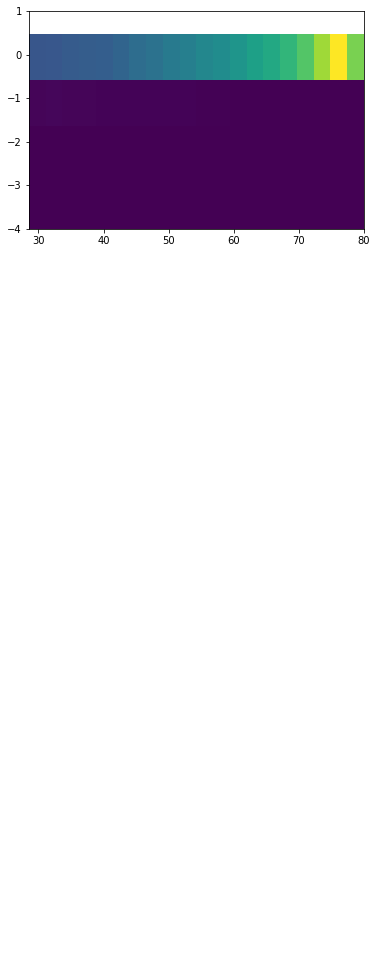

In [70]:
plt.hist2d(test_data["zenith"][test_data["zenith"] < 80], 
            test_data["temperature scale_surface_K"][test_data["zenith"] < 80], bins=20)
plt.ylim(-4, 1)